Importing necessary dependencies

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

2025-05-21 17:28:27.336563: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-21 17:28:27.427402: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-21 17:28:29.540091: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747827809.608791    5535 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747827809.631030    5535 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747827815.729465    5535 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Num GPUs Available: 0


E0000 00:00:1747827819.762988    5535 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1747827819.763982    5535 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
import os
import re
import nltk
import random
import pickle
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from tensorflow.keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/siddhu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/siddhu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 1. Loading our Data

In [4]:
DATA_PATH = "data/reviews.csv"
CLEANED_DATA_PATH = "data/cleaned_reviews.csv"
SAVED_WORD_COUNT_PATH = 'data/word_counts.csv'
TRAIN_SAVED_PATH = 'data/train_reviews.csv'
TEST_SAVED_PATH = 'data/test_reviews.csv'
SAVED_MODEL_PATH = 'model/lstm_model.pkl'
IMAGE_PATH = 'images/training_plot.png'
CLASSIFICATION_REPORT_PATH = "data/classification_report.csv"

In [5]:
# Reading our CSV file into a pandas DataFrame
df = pd.read_csv(DATA_PATH)
# Displaying the first three rows of the DataFrame
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# 2. Data Understanding, Analysis and Cleaning

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


Understand what is data about, Perform a basic data cleaning

## 2.1 Data Understanding

**Dataset Information**

> The original dataset contained more than 568k consumer reviews on different amazon products.


*   **Total Records**: *225443*
*   **Total Columns**: *10*
*   **Domain Name**: *amazon.com*
*   **File Extension**: *CSV*
*   **Available Fields**: *Id, ProductId, UserId, ProfileName, HelpfulnessNumerator, HelpfulnessDenomenator, Score, Time, Summary, Text*









**Checking for NULL values**

In [7]:
# Calculating the number of missing values in each column of the DataFrame
df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

**Checking dtype of every field in our dataset**

**Statistical description of numerical data**

In [8]:
# Displaying descriptive statistics of numerical columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,568454.0,2.842275e+05,1.640987e+05,1.0,1.421142e+05,2.842275e+05,4.263408e+05,5.684540e+05
HelpfulnessNumerator,568454.0,1.743817e+00,7.636513e+00,0.0,0.000000e+00,0.000000e+00,2.000000e+00,8.660000e+02
HelpfulnessDenominator,568454.0,2.228810e+00,8.289740e+00,0.0,0.000000e+00,1.000000e+00,2.000000e+00,9.230000e+02
Score,568454.0,4.183199e+00,1.310436e+00,1.0,4.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
Time,568454.0,1.296257e+09,4.804331e+07,939340800.0,1.271290e+09,1.311120e+09,1.332720e+09,1.351210e+09


## 2.3 Data Analysis

**Target Distribution**

Mapping and transforming the target

In [9]:
# Dictionary defining the mapping of numerical scores to sentiment labels
score_mappings = {
    1: 'negative',
    2: 'neutral',
    3: 'neutral',
    4: 'positive',
    5: 'positive'
}

# Mapping numerical scores to sentiment labels using the score_mappings dictionary
df['Score'] = df['Score'].map(score_mappings)

Plotting the count of our target classes

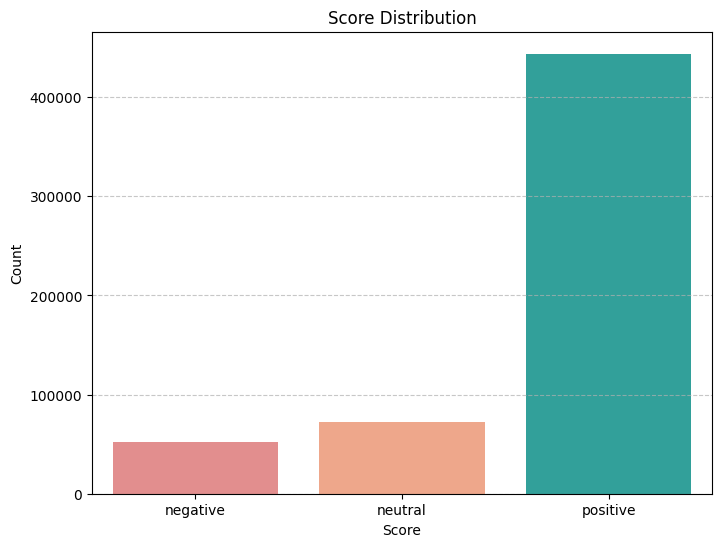

In [10]:
# Counting the occurrences of each sentiment score and sorting by index
score_counts = df['Score'].value_counts().sort_index()

# Define colors for each bar
colors = ['lightcoral', 'lightsalmon', 'lightseagreen']

# Creating the bar plot
plt.figure(figsize=(8, 6))
# Using seaborn's barplot to plot the counts of each sentiment score
sns.barplot(x=score_counts.index, y=score_counts, palette=colors, hue=score_counts.index, legend=False)
plt.title('Score Distribution')
plt.xlabel('Score')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotating x-axis labels for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)  # Adding grid lines to the y-axis
plt.show()

In [11]:
# Counting the occurrences of each sentiment score
df['Score'].value_counts()

Score
positive    443777
neutral      72409
negative     52268
Name: count, dtype: int64

> Removing duplicated Text

In [12]:
# Printing the number of records before dropping duplicates
print("Records before dropping duplicates: ", df.shape[0])
# Dropping duplicate rows based on the 'Text' column
df.drop_duplicates(subset=['Text'], keep='first', inplace=True)
# Printing the number of records after dropping duplicates
print("Records after dropping duplicates: ", df.shape[0])

Records before dropping duplicates:  568454
Records after dropping duplicates:  393579


Balancing our unbalanced dataset - Undersampling

In [13]:
# Set a random seed for reproducibility
np.random.seed(42)

# Define the number of samples for each sentiment score
sample_nums = 8000

# Randomly sample rows from each sentiment score category
df1 = df[df['Score'] == 'positive'].sample(sample_nums)
df2 = df[df['Score'] == 'neutral'].sample(sample_nums)
df3 = df[df['Score'] == 'negative'].sample(sample_nums)

# Concatenate the sampled DataFrames and shuffle the concatenated DataFrame
df = pd.concat([df1, df2, df3]).sample(frac=1).reset_index(drop=True)

Plotting the target count of balanced dataset

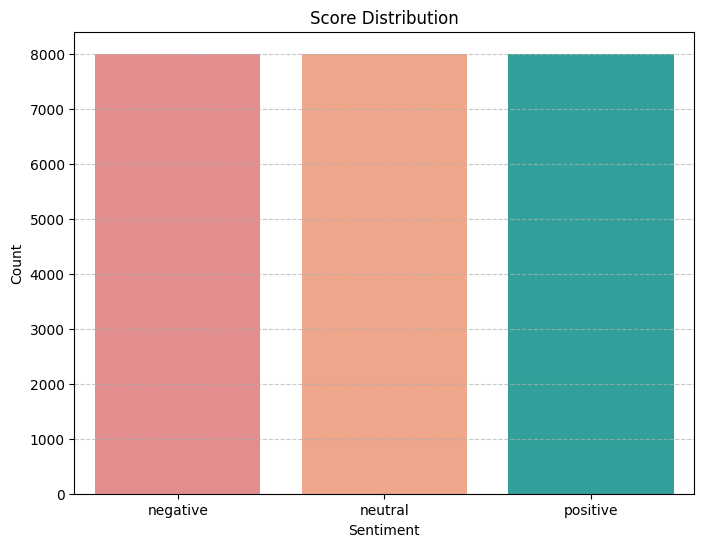

In [14]:
# Counting the occurrences of each sentiment label and sorting by index
score_counts = df['Score'].value_counts().sort_index()

# Define colors for each bar
colors = ['lightcoral', 'lightsalmon', 'lightseagreen']

# Creating the bar plot
plt.figure(figsize=(8, 6))
# Using seaborn's barplot to plot the counts of each sentiment label
sns.barplot(x=score_counts.index, y=score_counts, palette=colors, hue=score_counts.index, legend=False)
plt.title('Score Distribution')
plt.xlabel('Sentiment')  # Corrected x-axis label
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotating x-axis labels for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)  # Adding grid lines to the y-axis
plt.show()


## 1.2 Data Cleaning

### 1.2.1 Removing Unwanted Columns

> Removing unecessary feature columns

In [15]:
# Dropping specified columns from the DataFrame
df.drop(columns=['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Summary'], inplace=True)
# Displaying the first few rows of the DataFrame after dropping columns
df.head()

,Score,Text
0,negative,Regular oreos are about $3.00 for 15 oz. Thes...
1,neutral,"Love the Sunbutter, but only received one of t..."
2,negative,This was beyond disappointing. Just proved you...
3,positive,"This tasted fairly well, except, I was looking..."
4,positive,This soup is delicious just prepared as direct...


### 1.2.2 Removing Unwanted Characters and Words

> Removing URLs/Links and tagged person's username

In [16]:
def remove_urls(text):
    # Regular expression patterns for matching URLs and tags
    url_pattern = r'https?://(?:www\.)?\S+'  # Matches URLs starting with http:// or https://
    tag_pattern = r'@\w+'  # Matches tags starting with @ followed by word characters
    # Combining URL and tag patterns using the '|' operator to create a single pattern
    combined_pattern = f'({url_pattern})|({tag_pattern})'
    # Using re.sub() to replace matched patterns with an empty string, effectively removing them from the text
    cleaned_text = re.sub(combined_pattern, ' ', text)
    return cleaned_text  # Returning the cleaned text

In [17]:
# Example usage
example_text = "Our dataset @Siddhartha can be accessed using this link : https://www.kaggle.com/datasets/arhamrumi/amazon-product-reviews"
cleaned_text = remove_urls(example_text)
print("Original text:", example_text)
print("Cleaned text:", cleaned_text)

Original text: Our dataset @Siddhartha can be accessed using this link : https://www.kaggle.com/datasets/arhamrumi/amazon-product-reviews
Cleaned text: Our dataset   can be accessed using this link :  


> Removing Emojis 😨

In [18]:
def remove_emojis(text):
    # Regular expression pattern to match emojis
    emoji_pattern = re.compile("["
                    u"\U0001F600-\U0001F64F"  # Emoticons
                    u"\U0001F300-\U0001F5FF"  # Symbols & Pictographs
                    u"\U0001F680-\U0001F6FF"  # Transport & Map Symbols
                    u"\U0001F1E0-\U0001F1FF"  # Flags (iOS)
                    u"\U00002702-\U000027B0"
                    u"\U000024C2-\U0001F251"
                    "]+", flags=re.UNICODE)
    # Using re.sub() to replace matched emojis with an empty string, effectively removing them from the text
    return emoji_pattern.sub(r' ', text)

In [19]:
emoji_text = 'Hello @siman 👋🏾, still on up for the movie😁???  #MovieNight #friday #🍱'
cleaned_text = remove_emojis(emoji_text)
print("Original text:", emoji_text)
print("Cleaned text", cleaned_text)

Original text: Hello @siman 👋🏾, still on up for the movie😁???  #MovieNight #friday #🍱
Cleaned text Hello @siman  , still on up for the movie ???  #MovieNight #friday # 


> Removing HTML Tags

In [20]:
def remove_html_tags(text):
    # Regular expression pattern to match HTML tags
    pattern = re.compile(r'<.*?>')
    # Using re.sub() to replace matched HTML tags with an empty string, effectively removing them from the text
    cleaned_text = re.sub(pattern, ' ', text)
    return cleaned_text

In [21]:
# Example usage
original_text = "<p>This is <b>some</b> example <i>text</i> with <a href='#'>HTML</a> tags.</p>"
cleaned_text = remove_html_tags(original_text)
print("Original text:", original_text)
print("Cleaned text", cleaned_text)

Original text: <p>This is <b>some</b> example <i>text</i> with <a href='#'>HTML</a> tags.</p>
Cleaned text  This is  some  example  text  with  HTML  tags. 


> Removing Special Characters

In [22]:
def remove_special_characters(text):
    # Regular expression pattern to match any character that is not a letter (a-z, A-Z) or whitespace
    pattern = r'[^a-zA-Z\s]'
    # Using re.sub() to replace matched special characters with a space, effectively removing them from the text
    cleaned_text = re.sub(pattern, ' ', text)
    return cleaned_text

In [23]:
# Example usage
example_text = "This is 1 string's with special characters: .-_{[]},@#^&*!=+)($)\/?;|~`'"
cleaned_text = remove_special_characters(example_text)
print("Original text:", example_text)
print("Cleaned text:", cleaned_text)

Original text: This is 1 string's with special characters: .-_{[]},@#^&*!=+)($)\/?;|~`'
Cleaned text: This is   string s with special characters                              


### 1.2.3 Normalizing our text data

> Lowercasing

In [24]:
df['Text'] = df['Text'].str.lower()

> Lemmatization

In [25]:
# Creating a WordNetLemmatizer instance
lem = WordNetLemmatizer()

In [26]:
def lemmatize_text(text):
    # Tokenizing the input text into words, lemmatizing each word as a verb, and joining them back into a single string
    lemmatized_text = " ".join([lem.lemmatize(w, pos="v") for w in text.split()])
    return lemmatized_text

In [27]:
# Example usage
example_text = "I am running and jumping over the hurdles"
lemmatized_sentence = lemmatize_text(example_text)
print("Original sentence:", example_text)
print("Lemmatized sentence:", lemmatized_sentence)

Original sentence: I am running and jumping over the hurdles
Lemmatized sentence: I be run and jump over the hurdle


> Removing Stopwords

In [28]:
# Creating a set of English stopwords
STOPWORDS = set(stopwords.words('english'))
# Printing the list of stopwords
print(list(STOPWORDS))

["we've", 'isn', "wouldn't", 'ma', 'again', 'herself', 'hers', "aren't", 'ours', 'yourself', 'itself', 'them', 'haven', "you've", "couldn't", 'yourselves', 'when', 'am', 'to', "hasn't", 'will', "you'd", 'once', 'be', 'over', 'on', 'no', 'll', 'whom', "we'll", 'above', 'myself', 'same', 'how', "they're", 'into', 'few', 'too', "we're", "hadn't", 'don', 'been', 'from', "needn't", 'after', 'himself', "wasn't", 'his', "isn't", "it'd", 'doesn', 'this', 'being', "weren't", 'you', 'mightn', 'if', 'its', 'shouldn', 'do', "doesn't", 've', 'hadn', 'we', 'can', 'while', 'm', 'ain', 'needn', 'couldn', 'hasn', 'out', 's', "that'll", 'there', 'what', 'against', "don't", "i'm", "i've", 'up', 'off', 'he', 'below', 'under', 'y', "should've", "they'll", 'such', 'each', 'here', 'a', 'between', 'down', 'for', 'with', 'aren', 'only', 'mustn', 'some', 'then', 'any', 'nor', 'both', 'my', 'they', "we'd", 'own', 'in', "shouldn't", 'were', 'of', "she'll", 'yours', 'her', 'themselves', "mustn't", 'having', 'very'

In [29]:
CLEANED_STOPWORDS = []  # Initialize an empty list to store cleaned stopwords

# Iterate over each word in the set of stopwords
for word in list(STOPWORDS):
    cleaned_word = word.replace("'", "")  # Remove single quotes from the word
    CLEANED_STOPWORDS.append(cleaned_word)  # Append the cleaned word to the list

print(CLEANED_STOPWORDS)  # Print the list of cleaned stopwords


['weve', 'isn', 'wouldnt', 'ma', 'again', 'herself', 'hers', 'arent', 'ours', 'yourself', 'itself', 'them', 'haven', 'youve', 'couldnt', 'yourselves', 'when', 'am', 'to', 'hasnt', 'will', 'youd', 'once', 'be', 'over', 'on', 'no', 'll', 'whom', 'well', 'above', 'myself', 'same', 'how', 'theyre', 'into', 'few', 'too', 'were', 'hadnt', 'don', 'been', 'from', 'neednt', 'after', 'himself', 'wasnt', 'his', 'isnt', 'itd', 'doesn', 'this', 'being', 'werent', 'you', 'mightn', 'if', 'its', 'shouldn', 'do', 'doesnt', 've', 'hadn', 'we', 'can', 'while', 'm', 'ain', 'needn', 'couldn', 'hasn', 'out', 's', 'thatll', 'there', 'what', 'against', 'dont', 'im', 'ive', 'up', 'off', 'he', 'below', 'under', 'y', 'shouldve', 'theyll', 'such', 'each', 'here', 'a', 'between', 'down', 'for', 'with', 'aren', 'only', 'mustn', 'some', 'then', 'any', 'nor', 'both', 'my', 'they', 'wed', 'own', 'in', 'shouldnt', 'were', 'of', 'shell', 'yours', 'her', 'themselves', 'mustnt', 'having', 'very', 'id', 'most', 'ill', 'or'

In [30]:
def remove_stopwords(text):
    # Splitting the input text into words, removing stopwords, and joining the remaining words back into a single string
    stopwords_removed_text = " ".join([word for word in text.split() if word not in CLEANED_STOPWORDS])
    return stopwords_removed_text


In [31]:
example_text = "this is an example sentence with some stopwords that we want to remove."
normalized_text = remove_stopwords(example_text)
print("Original sentence:", example_text)
print("stopwords removed sentence:", normalized_text)

Original sentence: this is an example sentence with some stopwords that we want to remove.
stopwords removed sentence: example sentence stopwords want remove.


> Text Cleaning Pipeline

In [32]:
def text_cleaning_pipeline(df, text_column):
    # Iterate over each row in the DataFrame using tqdm for progress tracking
    for i, row in tqdm(df.iterrows(), total=len(df)):
        text = row[text_column]  # Get the text from the specified column
        # Apply each text cleaning function sequentially
        cleaned_text = remove_urls(text)
        cleaned_text = remove_emojis(cleaned_text)
        cleaned_text = remove_html_tags(cleaned_text)
        cleaned_text = remove_special_characters(cleaned_text)
        cleaned_text = lemmatize_text(cleaned_text)
        cleaned_text = remove_stopwords(cleaned_text)
        # Assign the cleaned text back to the DataFrame in a new column 'cleaned_text'
        df.at[i, 'cleaned_text'] = cleaned_text
    return df

> Cleaning our original dataframe using the text cleaning pipeline

In [33]:
# Check if the cleaned data file already exists
if not os.path.isfile(CLEANED_DATA_PATH):
    # If the file doesn't exist, apply the text cleaning pipeline to the original data
    cleaned_df = text_cleaning_pipeline(df=df, text_column='Text')
    # Save the cleaned data to the specified path as a CSV file without including the index
    cleaned_df.to_csv(CLEANED_DATA_PATH, index=False)
else:
    # If the file already exists, load the cleaned data from the specified path into a DataFrame
    cleaned_df = pd.read_csv(CLEANED_DATA_PATH)

In [34]:
cleaned_df.head()

,Score,Text,cleaned_text
0,positive,"i was surprised how sweet this cereal was, alt...",surprise sweet cereal although hold crunchines...
1,neutral,i thought i was buying a two-pack of this item...,think buy two pack item picture single bottle ...
2,neutral,i got this through a decaf keurig assortment p...,get decaf keurig assortment pack also amazon e...
3,negative,i am addicted to caramel apple cider - and bei...,addict caramel apple cider calories fairly ine...
4,neutral,"they were good, just like i remember them from...",good like remember childhood way overprice sur...


> Comparing a random cleaned and uncleaned text

In [35]:
# Generate a random index within the range of the length of the cleaned DataFrame
rand_idx = random.randint(0, len(cleaned_df) - 1)

# Print the original text and cleaned text corresponding to the randomly selected index
print(f"cleaned_df['Text'][{rand_idx}] : \n=> {cleaned_df['Text'][rand_idx]}\n")
print(f"cleaned_df['cleaned_text'][{rand_idx}] : \n=> {cleaned_df['cleaned_text'][rand_idx]}")

cleaned_df['Text'][19901] : 
=> never again will i assault my mouth with a product from this company. i'd rather eat a box of fermented jockstraps. maybe that's going a little far, but this... filth isn't fit to feed to my dogs. i think that the federal and state governments need to buy this wholesale and feed it to prisoners. you want reformed inmates? make them eat this and the us's prisons will be empty.<br /><br />1.) empty noodles into the box.<br />2.) gag.<br />3.) separate noodles with a fork.<br />4.) pour sauce over noodles.<br />5.) gag.<br />6.) heat for 2 minutes.<br />7.) stir concoction, gag, take a bite, spit it out, swallow your pride, and throw it away.<br />8.) eat something else.<br /><br />"what would you have wanted to know before you purchased the product?" that it tasted terrible. specifics: the noodles were rubbery, yet tore like parchment, and that the sauce was made from the condensed secretions of dung beetles and slugs.

cleaned_df['cleaned_text'][19901] : 

Word Cloud

In [36]:
from wordcloud import WordCloud
from collections import Counter

In [37]:
cleaned_df.isnull().sum()

Score           0
Text            0
cleaned_text    1
dtype: int64

In [38]:
cleaned_df.dropna(inplace=True)

In [39]:
# Define the path for the saved word counts file

# Check if the saved word counts file already exists
if not os.path.isfile(SAVED_WORD_COUNT_PATH):
    # If the file doesn't exist, initialize a Counter object to count words
    cnt = Counter()
    # Iterate over each cleaned text in the DataFrame and count the occurrences of each word
    for text in cleaned_df["cleaned_text"].values:
        for word in text.split():
            cnt[word] += 1
    # Convert the Counter object to a pandas DataFrame
    word_count_df = pd.DataFrame.from_dict(cnt, orient='index', columns=['count'])
    # Reset the index to make the words a column
    word_count_df.reset_index(inplace=True)
    word_count_df.columns = ['word', 'count']  # Rename columns for clarity
    # Save the word counts DataFrame to the specified path as a CSV file without including the index
    word_count_df.to_csv(SAVED_WORD_COUNT_PATH, index=False)
else:
    # If the file already exists, load the word counts from the specified path into a DataFrame
    word_count_df = pd.read_csv(SAVED_WORD_COUNT_PATH)

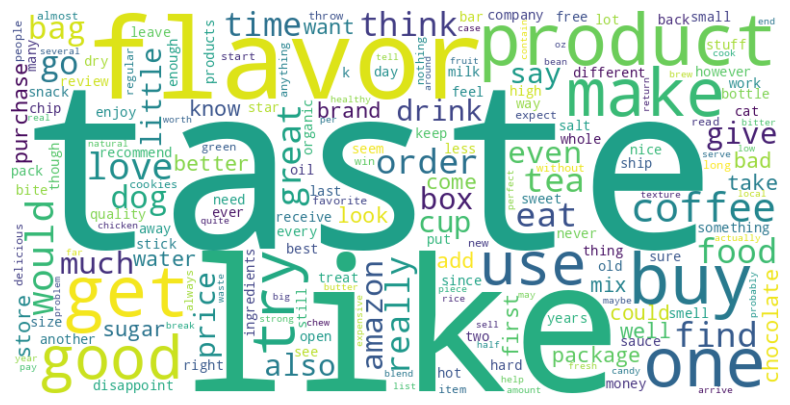

In [40]:
# Convert the DataFrame to a dictionary
word_counts = dict(zip(word_count_df['word'], word_count_df['count']))
# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('images/wordcloud_image_more.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

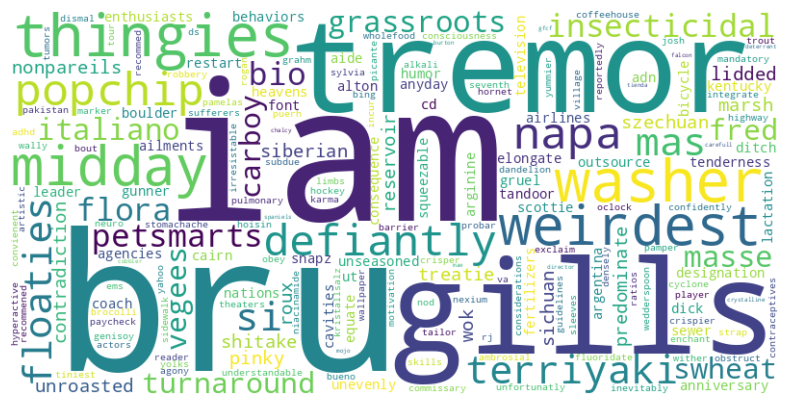

In [41]:
# Filter less frequent words
threshold = 5
word_count_df_filtered = word_count_df[word_count_df['count'] < threshold]
# Convert the filtered DataFrame to a dictionary
word_counts_filtered = dict(zip(word_count_df_filtered['word'], word_count_df_filtered['count']))
# Generate a word cloud for less frequent words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts_filtered)
# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
# Save the image
plt.savefig('images/wordcloud_image_low.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

> Dropping the Text column and null rows from cleaned dataframe

In [42]:
# Remove the 'Text' column from the DataFrame
cleaned_df = cleaned_df.drop(columns=['Text'])
# Drop rows with missing values in the 'cleaned_text' column
cleaned_df = cleaned_df.dropna(subset=['cleaned_text'])
# Check for any remaining missing values in the DataFrame
cleaned_df.isnull().sum()


Score           0
cleaned_text    0
dtype: int64

# 3. Build Model

> Function to Tokenize the input texts and convert it to sequences of integers

In [43]:
def embed_text(texts, max_words, max_len=1000):
    # Tokenize the texts and convert them into sequences of integers
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    # Determine the maximum sequence length
    max_len_seq = max([len(seq) for seq in sequences])
    max_len = min(max_len_seq, max_len)
    # Pad the sequences to ensure uniform length
    X = pad_sequences(sequences, maxlen=max_len)
    # Determine vocabulary size and return relevant information
    vocab_size = len(tokenizer.word_index) + 1  # Adding 1 for the padding token
    word_index = tokenizer.word_index
    return X, max_len, vocab_size, tokenizer, word_index

> Function to encode Multi-target labels

In [44]:
def encode_multi_class_target(target):
    # Initialize a label encoder
    label_encoder = LabelEncoder()
    # Fit and transform the target labels to encoded values
    target_encoded = label_encoder.fit_transform(target)
    # Determine the number of classes
    num_classes = len(label_encoder.classes_)
    # Convert the encoded target labels to categorical format
    targets_encoded = to_categorical(target_encoded, num_classes=num_classes)
    # Create a dictionary mapping encoded labels to original classes
    indexed_map = dict(enumerate(label_encoder.classes_))
    return targets_encoded, num_classes, indexed_map

> Function to create Model Architecture for RNN + LSTM for Text-Classification

In [45]:
def build_lstm_model(max_words, max_len, num_classes, embedding_dim=100, lstm_units=100):
    # Initialize a Sequential model
    model = Sequential()
    # Add an Embedding layer to convert integer indices to dense vectors of fixed size
    model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
    # Add an LSTM layer with dropout for sequence processing
    model.add(LSTM(units=lstm_units, dropout=0.4, recurrent_dropout=0.4))
    # Add a Dense layer with ReLU activation
    model.add(Dense(32, activation='relu'))
    # Add a Dropout layer for regularization
    model.add(Dropout(0.5))
    # Add a Dense layer with softmax activation for multi-class classification
    model.add(Dense(num_classes, activation='softmax'))
    # Compile the model with categorical crossentropy loss and Adam optimizer
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

> Splitting the cleaned dataframe to training and testing set

In [46]:
# Check if the train and test datasets exist
if not os.path.isfile(TRAIN_SAVED_PATH):
    # If the datasets don't exist, split the cleaned dataset into train and test sets
    train_df, test_df = tts(cleaned_df, test_size=0.2, random_state=42, stratify=cleaned_df['Score'])
    # Save the train and test datasets to the specified paths as CSV files without including the index
    train_df.to_csv(TRAIN_SAVED_PATH, index=False)
    test_df.to_csv(TEST_SAVED_PATH, index=False)
else:
    # If the datasets already exist, load the train and test datasets from the specified paths
    train_df = pd.read_csv(TRAIN_SAVED_PATH)
    test_df = pd.read_csv(TEST_SAVED_PATH)

# Print the shapes of the train and test datasets
print("Train shape : ", train_df.shape)
print("Test shape : ", test_df.shape)


Train shape :  (23596, 2)
Test shape :  (5899, 2)


> Separating our feature and target for training and testing

In [47]:
X_train = train_df.cleaned_text.values
y_train = train_df.Score.values
X_test = test_df.cleaned_text.values
y_test = test_df.Score.values

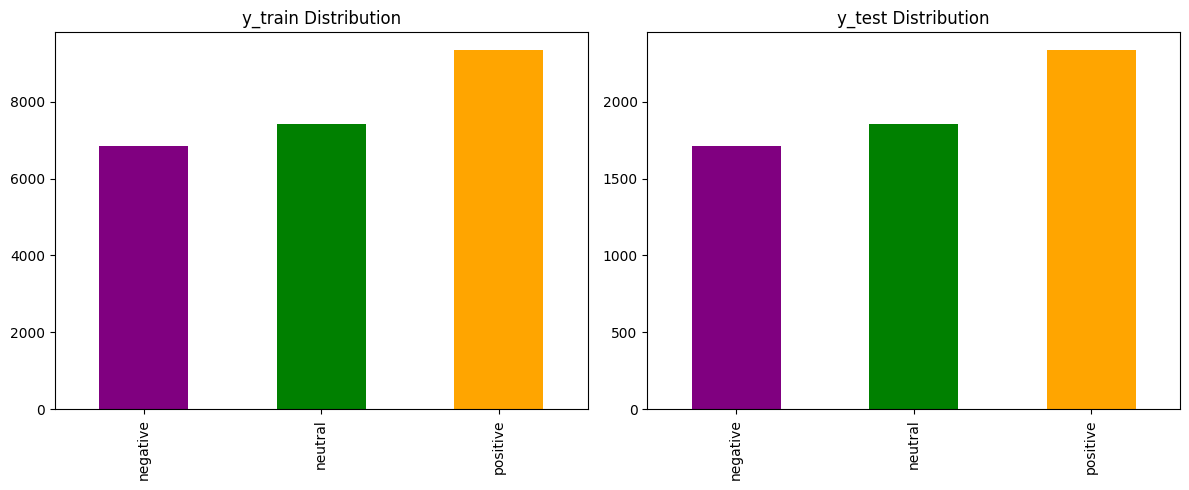

In [48]:
# Data Distribution visualization
plt.figure(figsize=(12, 5))

# Plot y_train
plt.subplot(1, 2, 1)
pd.Series(y_train).value_counts().sort_index().plot(kind="bar", color=["purple", "g", "orange"])
plt.title("y_train Distribution")

# Plot y_test
plt.subplot(1, 2, 2)
pd.Series(y_test).value_counts().sort_index().plot(kind="bar", color=["purple", "g", "orange"])
plt.title("y_test Distribution")
plt.tight_layout()
plt.show()

> Embedding our Text data: Preparing Text Data

In [49]:
MAX_WORDS = 10000  # Maximum number of words to be considered in the vocabulary
# Replace NaNs and non-string types in the NumPy array
X_train = np.array([str(text) if isinstance(text, str) else "" for text in X_train])
# Embed the text features of the training dataset
X_train_embed, max_len, vocab_size, tokenizer, word_index = embed_text(texts=X_train, max_words=MAX_WORDS)

# Print information about the embedding
print("Input shape : ", X_train_embed.shape)  # Shape of the embedded input
print("Max len : ", max_len)  # Maximum sequence length
print("Vocab size : ", vocab_size)  # Size of the vocabulary
# Print the first 12 items using slicing
print("Word index : ", list(word_index.items())[:12])

Input shape :  (23596, 860)
Max len :  860
Vocab size :  23148
Word index :  [('taste', 1), ('like', 2), ('flavor', 3), ('product', 4), ('get', 5), ('buy', 6), ('one', 7), ('make', 8), ('good', 9), ('use', 10), ('try', 11), ('coffee', 12)]


> Multi-Class Target Encoding

Example:

negative => [1, 0, 0]

neural => [0, 1, 0]

positive => [0, 0, 1]

In [50]:
# Encode the multi-class target labels of the training dataset
y_train_encoded, num_classes, indexed_map = encode_multi_class_target(target=y_train)

# Print information about the encoding
print("Num classes : ", num_classes)  # Number of classes in the target labels
print("Target shape : ", y_train.shape)  # Shape of the original target labels
print("Indexed map : ", indexed_map)  # Dictionary mapping encoded labels to original classes

Num classes :  3
Target shape :  (23596,)
Indexed map :  {0: 'negative', 1: 'neutral', 2: 'positive'}


Building LSTM + RNN Model

In [51]:
BATCH_SIZE = 32  # Batch size for training
# Build the RNN model
model = build_lstm_model(max_words=MAX_WORDS, max_len=max_len, num_classes=num_classes)
# Set the input shape based on the batch size and maximum sequence length
model.build(input_shape=(BATCH_SIZE, max_len))
# Print a summary of the model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (32, 860, 100)         │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (32, 100)              │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 32)               │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 32)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,083,731 (4.13 MB)

 Trainable params: 1,083,731 (4.13 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
EPOCHS = 10  # Number of epochs for training

# Check if the saved model file exists
if not os.path.isfile(SAVED_MODEL_PATH):
    # If the model file doesn't exist, configure early stopping and train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train_embed,  # Input features (embedded text)
        y_train_encoded,  # Target labels (encoded)
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.2,  # Validation split for monitoring
        callbacks=[early_stopping]  # Early stopping callback to prevent overfitting
    )
    # Save the trained model to a file using pickle
    with open(SAVED_MODEL_PATH, "wb") as pickle_lstm:
        pickle.dump(model, pickle_lstm)
    pickle_lstm.close()
else:
    # If the model file exists, load the saved model from the file
    with open(SAVED_MODEL_PATH, "rb") as pickle_lstm:
        model = pickle.load(pickle_lstm)
    pickle_lstm.close()

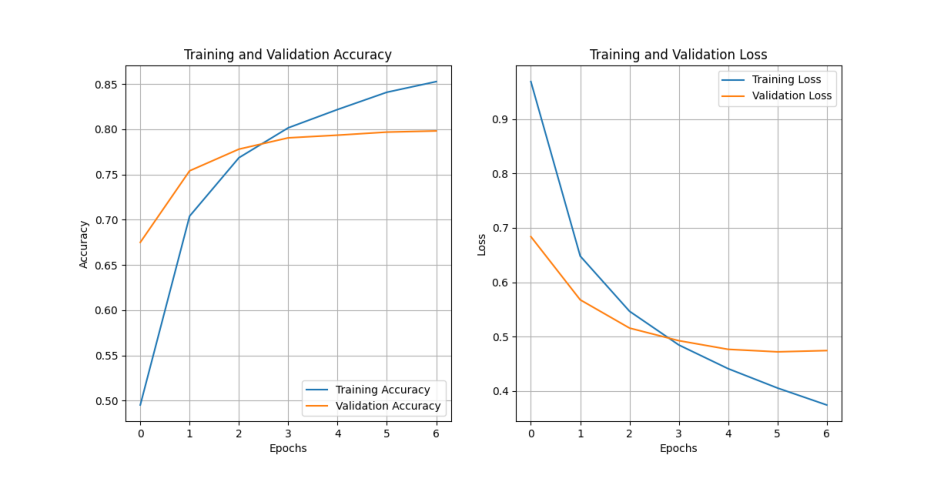

In [53]:
# Check if the image file already exists
if not os.path.exists(IMAGE_PATH):
    # If the image file doesn't exist, plot the training and validation metrics
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))  # Assuming the length of history is the same as the number of epochs

    # Plot training and validation accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)

    # Save the plot as an image file
    plt.savefig(IMAGE_PATH)
    plt.show()
else:
    # If the image file exists, load and display the existing image
    img = plt.imread(IMAGE_PATH)
    plt.figure(figsize=(12, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [54]:
def evaluate_rnn(model, texts, labels, tokenizer, indexed_map, max_len):
    # Convert text sequences to sequences of integer indices
    sequences = tokenizer.texts_to_sequences(texts)
    # Pad sequences to ensure uniform length
    X_test = pad_sequences(sequences, maxlen=max_len)
    # Make predictions using the model and get the predicted class indices
    predictions = np.argmax(model.predict(X_test), axis=1)
    # Map predicted class indices to their corresponding labels
    predictions_str = [indexed_map[pred] for pred in predictions]
    # Calculate accuracy by comparing predicted labels with true labels
    accuracy = accuracy_score(labels, predictions_str)
    # Compute confusion matrix to assess model performance
    cm = confusion_matrix(labels, predictions_str)
    return accuracy, cm

In [55]:
y_test_encoded, num_classes, indexed_map = encode_multi_class_target(target=y_test)
y_test_encoded

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [56]:
indexed_map

{0: 'negative', 1: 'neutral', 2: 'positive'}

In [57]:
test_accuracy, test_cm = evaluate_rnn(model=model, texts=X_test, labels=y_test, tokenizer=tokenizer, indexed_map=indexed_map, max_len=max_len)

185/185 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step


In [58]:
train_accuracy, train_cm = evaluate_rnn(model=model, texts=X_train, labels=y_train, tokenizer=tokenizer, indexed_map=indexed_map, max_len=max_len)

2025-05-21 17:29:09.939807: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 81170240 exceeds 10% of free system memory.


738/738 ━━━━━━━━━━━━━━━━━━━━ 53s 71ms/step


In [59]:
print("Test accuracy => ", test_accuracy)
print("Train accuracy => ", train_accuracy)

Test accuracy =>  0.7979318528564163
Train accuracy =>  0.8688760806916427


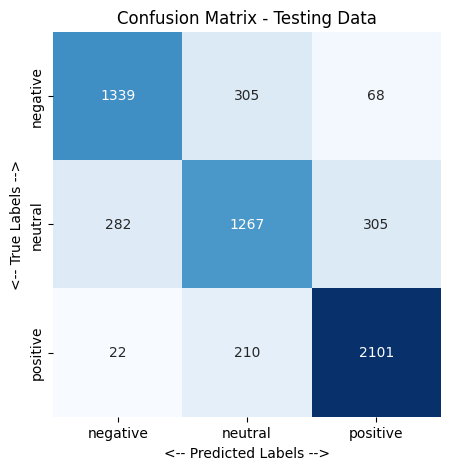

In [60]:
# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
# Labels and title with original Class
plt.xticks(ticks=np.arange(
          len(indexed_map)) + 0.5,
          labels=[indexed_map[i] for i in range(len(indexed_map))]
          )
plt.yticks(ticks=np.arange(
          len(indexed_map)) + 0.5,
          labels=[indexed_map[i] for i in range(len(indexed_map))]
          )
plt.xlabel('<-- Predicted Labels -->')
plt.ylabel('<-- True Labels -->')
plt.title('Confusion Matrix - Testing Data')
# Show plot
plt.show()

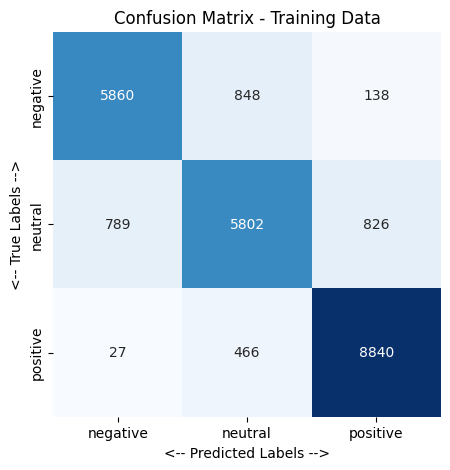

In [61]:
# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(train_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
# Labels and title with original Class
plt.xticks(ticks=np.arange(
          len(indexed_map)) + 0.5,
          labels=[indexed_map[i] for i in range(len(indexed_map))]
          )
plt.yticks(ticks=np.arange(
          len(indexed_map)) + 0.5,
          labels=[indexed_map[i] for i in range(len(indexed_map))]
          )
plt.xlabel('<-- Predicted Labels -->')
plt.ylabel('<-- True Labels -->')
plt.title('Confusion Matrix - Training Data')
# Show plot
plt.show()

In [62]:
def classify_sentiment(model, indexed_map, tokenizer, text, max_len):
    # Convert the text to a sequence of integer indices
    text_sequence = tokenizer.texts_to_sequences([text])
    # Pad the sequence to ensure uniform length
    encoded_text = pad_sequences(text_sequence, maxlen=max_len)
    # Make predictions using the model
    predictions = model.predict(encoded_text, verbose=0)
    # Get the predicted class index
    predicted_index = np.argmax(predictions, axis=1)[0]
    # Map the predicted class index to its corresponding sentiment label
    predicted_sentiment = indexed_map[predicted_index]
    return predictions, predicted_sentiment

In [63]:
cm_df = pd.DataFrame()
cm_df['x_test'] = X_test
cm_df['y_test'] = y_test
cm_df.head()

,x_test,y_test
0,manufacturer refuse admit problem capsule work...,negative
1,write many dent careless handle also broth ope...,negative
2,corn kernels small pop result small pop corn g...,neutral
3,convert kitchen organic spice make spice mix s...,positive
4,love lindor truffles terrible shape old box mo...,negative


In [64]:
if os.path.exists(CLASSIFICATION_REPORT_PATH):
    cm_df = pd.read_csv(CLASSIFICATION_REPORT_PATH)
    print("Loaded existing CSV.")
else:
    for i, row in tqdm(cm_df.iterrows(), total=len(cm_df)):
        text = row["x_test"]
        predictions, predicted_sentiment = classify_sentiment(model=model, indexed_map=indexed_map, tokenizer=tokenizer, text=text, max_len=max_len)
        cm_df.at[i, 'predicted'] = predicted_sentiment
    cm_df.to_csv(CLASSIFICATION_REPORT_PATH, index=False)

Loaded existing CSV.


In [65]:
cm_df.head()

,x_test,y_test,predicted
0,manufacturer refuse admit problem capsule work...,negative,neutral
1,write many dent careless handle also broth ope...,negative,negative
2,corn kernels small pop result small pop corn g...,neutral,neutral
3,convert kitchen organic spice make spice mix s...,positive,positive
4,love lindor truffles terrible shape old box mo...,negative,neutral


In [66]:
# Generate the classification report
report = classification_report(cm_df['y_test'], cm_df['predicted'])
# Print the classification report
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

    negative       0.81      0.78      0.80      1712
     neutral       0.71      0.68      0.70      1854
    positive       0.85      0.90      0.87      2333

    accuracy                           0.80      5899
   macro avg       0.79      0.79      0.79      5899
weighted avg       0.80      0.80      0.80      5899



In [67]:
text = input("Enter your review : ")
predictions, res = classify_sentiment(model=model, indexed_map=indexed_map,tokenizer=tokenizer, text=text, max_len=max_len)
print("Sentiment Probabilities : \n")
print(f"Negative score : {predictions[0][0]:.5f}")
print(f"Neutral score : {predictions[0][1]:.5f}")
print(f"Positive score : {predictions[0][2]:.5f}")
print("----------------------------------")
print("Sentiment => ", res)

Sentiment Probabilities : 

Negative score : 0.00882
Neutral score : 0.08696
Positive score : 0.90422
----------------------------------
Sentiment =>  positive
